# Countryside Survey

Countryside Survey is a unique study or ‘audit’ of the natural resources of the UK’s countryside. The Survey has been carried out at discrete intervals since 1978. The countryside is sampled and studied using rigorous scientific methods, allowing results to be compared with those from previous surveys. In this way the quantity and quality of change in our landscapes can be recorded and even the most gradual and subtle changes that occur in the UK’s countryside over time can be detected. This evidence is used to help form policies that influence management of the countryside, both now and in the future.

**Server** [/1.0/2069de82-619d-4751-9904-aec8500d07e6](https://data-eidc.ceh.ac.uk/1.0/2069de82-619d-4751-9904-aec8500d07e6)

**Documentation** <https://data-eidc.ceh.ac.uk/docs/cs>

### 🔒 Authentication

Create a token with [Data API Auth](https://data-eidc.ceh.ac.uk/authentication) with the following **LICENCES** (LICENCE_OGL)

## Step 1: Install dependencies

In [173]:
!pip install bng_latlon

import math
import json
import pprint
import time
from io import BytesIO, StringIO

from latlon_to_bng import WGS84toOSGB36
from bng_to_latlon import OSGB36toWGS84
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import numpy as np
import pandas
import requests

## Step 2: Set the token

**WARNING** do not share tokens publicly, get them from secure environment variables or secure files. You can revoke a token at anytime and set the expiry such that if you do intend to share a notebook you do not compromise your tokens.


Here is an example of how to read the token from a file, in Colab open Files tab and click "Mount Drive" button and you should be able to do something similar to the following.

In [174]:
import os
#os.listdir('drive/My Drive')
f = open('token.txt', "r")
token = f.read()

## Step 3: Request the data

The following are some functions which will allow you to fetch the data

In [175]:
url = 'https://data-eidc.ceh.ac.uk/1.0/2069de82-619d-4751-9904-aec8500d07e6'

# Go to here for more info on the endpoints https://data-eidc.ceh.ac.uk/docs/cs

# The /metadata endpoint

def metadata(params={}):
    res = requests.get(
        "{}/metadata".format(url),
        params=params,
        headers={
            "Authorization": "Bearer {}".format(token)
        }
    )
    return res.json()


# The /metadata/key/{key} endpoint

def key_values(key):
    res = requests.get(
        "{}/metadata/key/{}".format(url, key),
        headers={
            "Authorization": "Bearer {}".format(token)
        }
    )
    return res.json()


# The /data endpoint. Using POST over GET as it is easier to manipulate the body in python over the query parameters

def post(params):
    res = requests.post(
        "{}/data".format(url),
        data=json.dumps(params),
        headers={
            "Authorization": "Bearer {}".format(token),
            "Accept": "text/csv",
            "Content-Type": "application/json"
        }
    )
    if not res.ok:
        return res.content
    return pandas.read_csv(BytesIO(res.content))


## Metadata Request

The Countryside Survey Data API has a metadata endpoint which allows you to automate your scripts without the need for worrying about typos or if the metadata changes e.g. more data is added.

The metadata is derived from the data EIDC catalogue <https://catalogue.ceh.ac.uk/documents/2069de82-619d-4751-9904-aec8500d07e6>

In [176]:
# Example metadata query for all vegetation in the year 2007

metadata({
    "tags": ["veget"], #  read here: https://data-eidc.ceh.ac.uk/docs/cs?schema=16
    "years": ["2007"]
})

[{'acronym': 'vp',
  'columns': [{'name': 'YEAR', 'type': 'int64'},
   {'name': 'SQUARE', 'type': 'string'},
   {'name': 'PLOT', 'type': 'string'},
   {'name': 'AMALG_PTYPE', 'type': 'string'},
   {'name': 'BRC_NUMBER', 'type': 'float64'},
   {'name': 'BRC_NAMES', 'type': 'string'},
   {'name': 'NEST_LEVEL', 'type': 'float64'},
   {'name': 'ZERO_COVER', 'type': 'float64'},
   {'name': 'FIRST_COVER', 'type': 'float64'},
   {'name': 'TOTAL_COVER', 'type': 'float64'},
   {'name': 'PLOT_TYPE', 'type': 'string'},
   {'name': 'COUNTRY', 'type': 'string'},
   {'name': 'ENV_ZONE_2007', 'type': 'int64'},
   {'name': 'EZ_DESC_07', 'type': 'string'},
   {'name': 'WORDS', 'type': 'string'},
   {'name': 'TAG', 'type': 'string'},
   {'name': 'UID', 'type': 'string'},
   {'name': 'PARENT', 'type': 'string'}],
  'files': [{'columns': ['YEAR',
     'SQUARE_ID',
     'PLOT_ID',
     'AMALG_PTYPE',
     'BRC_NUMBER',
     'BRC_NAMES',
     'NEST_LEVEL',
     'ZERO_COVER',
     'FIRST_COVER',
     'TOTAL_

### Metadata breakdown

 key | description
 ---|---
`acronym` | Shorthand for datasets
`columns` | All the columns in the dataset, quicker than getting the data and interogating it, it also describe the format of each column
`files` | Each dataset has different files, if you want to know where the data originally came from. This also describes the columes of the data
`parent` | Each dataset is part of a parent dataset which you can go search for in the EIDC catalogue
`parent_title` | The title of the parent dataset
`tag` | A common tag for datasets which share similar data, this value is derived from the Catalogue
`title` | The title of the dataset in the catalogue
`uid` | The id of the dataset which you can use to find in the catalogue
`words` | Keywords from the title which may be useful for understanding the dataset without having to read all the metadata (alone)
`year` | The year the dataset was taken

### Merging datasets together

You can also merge datasets together, for example the `soil` and `vegetation`. The Data API will attempt to merge them together using a outer join on common column names. This might always be the desired dataset.

If you want to know what the dataset will attempt to merge run the metadata endpoint first and if you are happy continue

**WARNING** merging the with the `landscap` tag may result in a long wait or possible no result at all, this is a known issue and is being worked on. We suggest you query `landscap` seperatly

In [177]:
# Check to see if veget and soil merge will give the expected dataframe

res = metadata({
    "tags": ["veget", "soil"]
})

In [178]:
for value in res:
  print(value['year'], value['title'])

2007 Soil aggregate stability data from arable and grassland in Countryside Survey, Great Britain 2007 
2000 Soil invertebrate data 1998 [Countryside Survey]
2007 Soil invertebrate data 2007 [Countryside Survey]
2000 Soil metals data 1998 [Countryside Survey]
2007 Soil metals data 2007 [Countryside Survey]
1978 Soil physico-chemical properties 1978 [Countryside Survey]
2000 Soil physico-chemical properties 1998 [Countryside Survey]
2007 Soil physico-chemical properties 2007 [Countryside Survey]	
2007 Topsoil mineralisable nitrogen (mineral-N) data 2007 [Countryside Survey]
1978 Countryside Survey 1978 vegetation plot data
1990 Countryside Survey 1990 vegetation plot data
2000 Countryside Survey 1998 vegetation plot data
2007 Countryside Survey 2007 vegetation plot data


## Key Values

This endpoint lists all values for a given key which can be used for automation of your scripts, or to discover what values might be available

In [179]:
# Get all the years of the data

years = key_values('year')
years

['1978', '1984', '1990', '2000', '2007']

In [180]:
# Get all the tags of the data

tags = key_values('tag')
tags

['featur', 'habitat', 'landscap', 'mite', 'river', 'soil', 'veget', 'wat']

## Data endpoint

The data endpoint is where you can query the Data API to get the data in either JSON or CSV format. It automatically combines common data together and will attempt to merge datasets together. See metadata above for more info on this.

By way of example we have 3 seperate queries which will showcase some of the capabilities of the Countryside Survey Data API `/data` endpoint.

### Example Query 1:
*Combining the Landscape dataset and the vegetation dataset for all the years*

> What is the cover of all the vegetation in Bogs (over all years)?

#### Steps

1. Get all the `SQUARES` from the landscape data which are of type `Bog` i.e. from the data matching the tag `landscap`
2. Get all the vegetation data i.e. matching tag `veget`
3. Select all the vegetation over these squares
4. Display the result

In [181]:
# Since we read the WARNING above we are querying the landscap dataset separate to the vegetation dataset and then we do not need to make another request for the data as it will be stored in memory

bog_squares = post({ "metadata": { 'tags': ["landscap"] }, "columns": ["SQUARE"], "query": "BROAD_HABITAT_NAME == 'Bog'" })
veget = post({ "metadata": { "tags": ["veget"] } })

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [182]:
bog_veget = veget[veget['SQUARE'].isin(bog_squares['SQUARE'].values)]

In [183]:
brc_names = bog_veget['BRC_NAMES'].dropna().drop_duplicates()
years = bog_veget['YEAR'].dropna().drop_duplicates()

In [184]:
# Getting the total cover for each plant, for each year in order to plot along the X axis of a line chart

xs = []
for brc_name in brc_names[0:10]:
  x = []
  for year in years:
    mean = bog_veget[bog_veget['BRC_NAMES'] == brc_name][bog_veget['YEAR'] == year]['TOTAL_COVER'].mean()
    x.append(mean)
  xs.append(x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


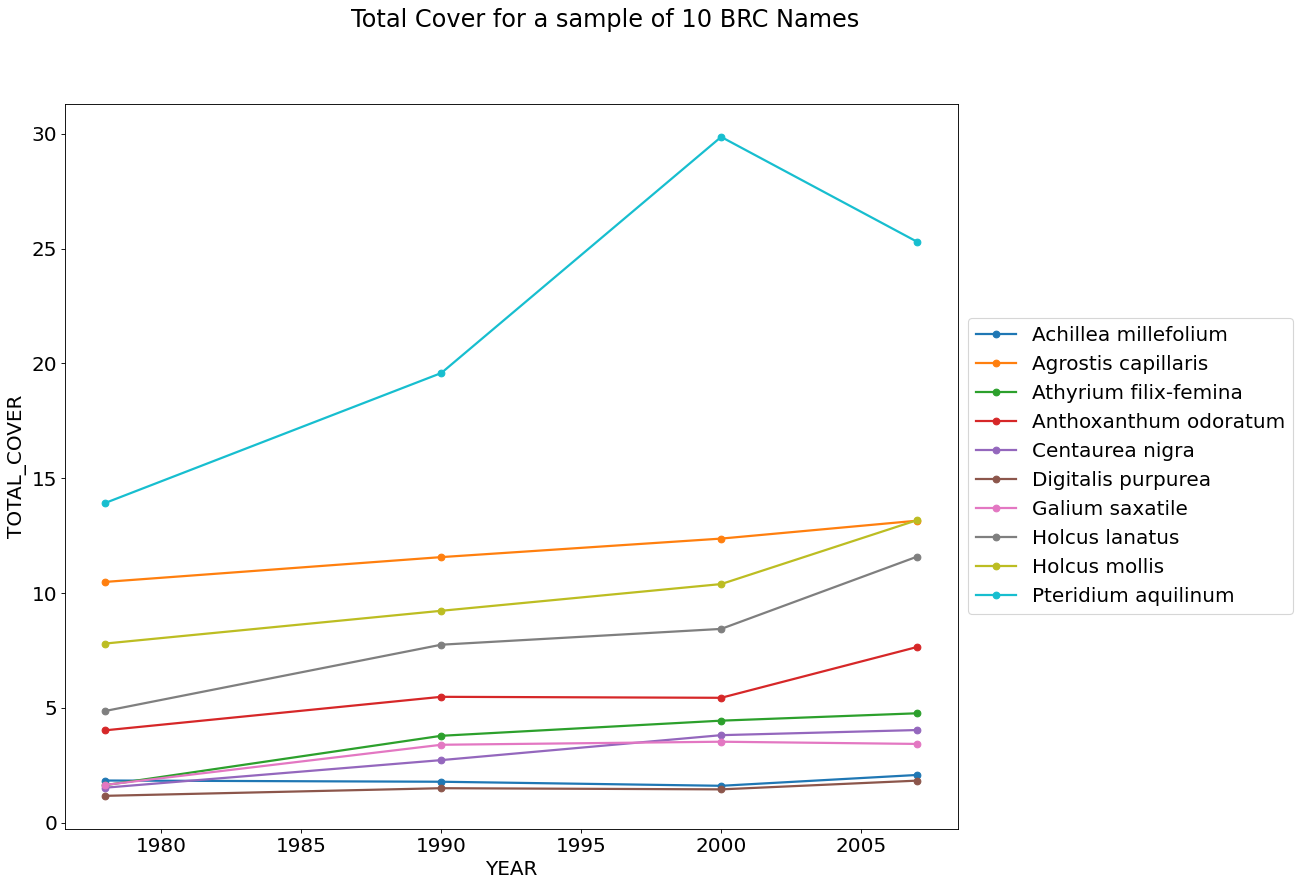

In [186]:
# Fancy plot work

figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')

font = { 'size' : 18 }
rc('font', **font)

plt.ylabel('TOTAL_COVER')
plt.xlabel('YEAR')
plt.suptitle('Total Cover for a sample of 10 BRC Names')

ax = plt.gca()
i = 0
for x in xs:
  ax.plot(years, x,'-o', linewidth=2.0, label=brc_names[i],)
  i = i + 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Example Query 2:

*Spatial query*

> What are the soil moisture readings across Cumbria for the year 2007?

#### Steps

1. Setup the bounding box of cumbria and break into 10k grid
2. For each grid see if there is any `MOISTURE` data i.e. using the tag `soil`
3. Display the result

In [14]:
# Creating a bounding box using lat,lon and converting them to BNG (British National Grid) values

cumbria = [54.031973,-3.652954,55.182984,-2.238464]

cumbria_south_west = WGS84toOSGB36(cumbria[0], cumbria[1])
cumbria_north_east = WGS84toOSGB36(cumbria[2], cumbria[3])

s = cumbria_south_west[1]
n = cumbria_north_east[1]
sn = range(round(s), round(n), 10000)
w = cumbria_south_west[0]
e = cumbria_north_east[0]
we = range(round(w), round(e), 10000)

In [53]:
# For each 10k square in our bounding box we are getting soil data but we only want the mean of the moisture. Not all the plots will have data so we ignore those values

X, Y = np.meshgrid(we, sn)
Z = np.zeros_like(X) + np.zeros_like(Y)

for i in range(13):
  for j in range(10):
    x = X[i][j]
    y = Y[i][j]
    data = post({
      "metadata": {
          "tags": ["soil"],
          "years": ["2007"]
      },
      "spatial": {
          "east": int(x),
          "north": int(y)
      },
      "columns": ["MOISTURE"]
    })
    if not type(data) is bytes:
      value = data['MOISTURE'].mean()
      if math.isnan(value):
        value = 0
      Z[i][j] = value

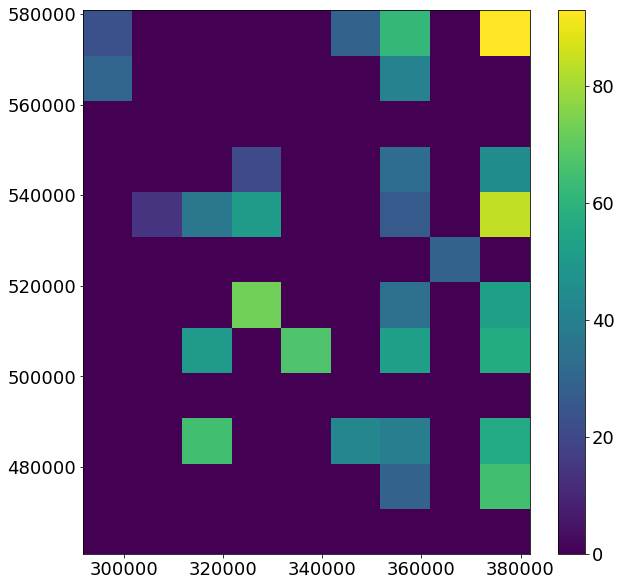

In [54]:
# Fancy plot work

figure(num=None, figsize=(10, 10))
plt.pcolormesh(X,Y, Z)
plt.colorbar()
plt.show()

### Example Query 3:

*A single query over multiple datasets, using a complex filter*

> Are there any places where Calluna vulgaris or Erica tetrallix survive in soil with a "high" `PB` concentration (over all years)?

#### Steps

1. Do a single query for soil and vegetation where `PB > 100`
2. Display the result

In [17]:
# This is a complex query over both soil and vegetation

soil_veget_pb = post({
    "metadata": {
        "tags": ["soil", "veget"]
    },
    "query": "PB > 100 and (BRC_NAMES == 'Calluna vulgaris' or BRC_NAMES == 'Erica tetralix')",
    "columns": ["YEAR", "PLOT", "BRC_NAMES", "PB"]
})

In [49]:
# What? No fancy plot?

#for col in soil_veget_pb.columns: 
#    print(col) 

data = post({
  "metadata": {
      "tags": ["soil"],
      #"years": ["2007"]
  },
  "spatial": {
      "east": int(X[11][8]),
      "north": int(Y[11][8])
  },
  #"columns": ["MOISTURE"]
})
data

,SQUARE,PLOT,MWD1,MWD2,DR,LC07,LC07_NUM,COUNTRY,COUNTY07,EZ_DESC_07,...,C_CONC_LOI,C_STOCK_LOI,N_PERCENT,PO4_OLSEN,BULK_DENSITY,MOISTURE,N_STOCK,NE_NMINTOT,MIN_N_STOCK,NE_NO3N_PROP_NMIN
0,WJHOZP,BDNQYPRHHK,NaN,NaN,NaN,22e,22,ENG,Northumberland,Uplands (England),...,397.724525,56.389200,NaN,NaN,0.094520,91.590972,NaN,NaN,NaN,NaN
1,WJHOZP,CJVXIRNAVF,NaN,NaN,NaN,22e,22,ENG,Northumberland,Uplands (England),...,519.211330,23.533611,NaN,NaN,0.030217,97.052360,NaN,NaN,NaN,NaN
2,WJHOZP,KOFMDCJMHH,NaN,NaN,NaN,22e,22,ENG,Northumberland,Uplands (England),...,520.263480,27.878440,NaN,NaN,0.035723,96.564768,NaN,NaN,NaN,NaN
3,WJHOZP,MKFXLGJCAQ,NaN,NaN,NaN,22e,22,ENG,Northumberland,Uplands (England),...,506.100320,17.308560,NaN,NaN,0.022800,97.274669,NaN,NaN,NaN,NaN
4,WJHOZP,WFBFPDHTKM,NaN,NaN,NaN,22e,22,ENG,Northumberland,Uplands (England),...,532.180495,67.295871,NaN,NaN,0.084302,86.372711,NaN,NaN,NaN,NaN


In [40]:
# This is a complex query over both soil and vegetation

soil_veget_pb = post({
    "metadata": {
        "tags": ["soil", "veget"]
    },
    "query": "PB > 100 and (BRC_NAMES == 'Calluna vulgaris' or BRC_NAMES == 'Erica tetralix')",
    "columns": ["YEAR", "PLOT", "BRC_NAMES", "PB"]
})
soil_veget_pb

AttributeError: 'bytes' object has no attribute 'colnames'

In [24]:
veget

,YEAR,SQUARE,PLOT,PLOT_TYPE,COUNTRY,ENV_ZONE_2007,EZ_DESC_07,AMALG_PTYPE,BRC_NUMBER,BRC_NAMES,TOTAL_COVER,NEST_LEVEL,FIRST_COVER,ZERO_COVER
0,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,9207.0,Achillea millefolium,1.0,NaN,NaN,NaN
1,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,92040.0,Agrostis capillaris,1.0,NaN,NaN,NaN
2,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,910211.0,Athyrium filix-femina,1.0,NaN,NaN,NaN
3,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,920121.0,Anthoxanthum odoratum,1.0,NaN,NaN,NaN
4,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,920444.0,Centaurea nigra,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781111,2007,VMLMLA,LEUYCPQEST,A,ENG,1,Easterly lowlands (England),NaN,NaN,NaN,NaN,NaN,NaN,NaN
781112,2007,WGFZAS,ILVPPKPUER,R,ENG,1,Easterly lowlands (England),NaN,NaN,NaN,NaN,NaN,NaN,NaN
781113,2007,XGHBPM,AGHFAYUNXC,D,SCO,4,Lowlands (Scotland),NaN,NaN,NaN,NaN,NaN,NaN,NaN
781114,2007,XGHBPM,JYSNPAVGGF,D,SCO,4,Lowlands (Scotland),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
veget[veget['SQUARE'] == 'CIOSPC']

,YEAR,SQUARE,PLOT,PLOT_TYPE,COUNTRY,ENV_ZONE_2007,EZ_DESC_07,AMALG_PTYPE,BRC_NUMBER,BRC_NAMES,TOTAL_COVER,NEST_LEVEL,FIRST_COVER,ZERO_COVER
0,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,9207.0,Achillea millefolium,1.0,NaN,NaN,NaN
1,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,92040.0,Agrostis capillaris,1.0,NaN,NaN,NaN
2,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,910211.0,Athyrium filix-femina,1.0,NaN,NaN,NaN
3,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,920121.0,Anthoxanthum odoratum,1.0,NaN,NaN,NaN
4,1978,CIOSPC,TTBHAMWAIG,H,ENG,2,Westerly lowlands (England),H,920444.0,Centaurea nigra,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536433,2007,CIOSPC,WOIDAVOCQN,U,ENG,2,Westerly lowlands (England),U,920983.0,Holcus lanatus,1.0,1.0,NaN,NaN
536434,2007,CIOSPC,WOIDAVOCQN,U,ENG,2,Westerly lowlands (England),U,8201132.0,Dicranum sp.,1.0,1.0,NaN,NaN
536435,2007,CIOSPC,WOIDAVOCQN,U,ENG,2,Westerly lowlands (England),U,9101619.0,Pteridium aquilinum,60.0,1.0,NaN,NaN
536436,2007,CIOSPC,WOIDAVOCQN,U,ENG,2,Westerly lowlands (England),U,9201588.0,Potentilla erecta,1.0,1.0,NaN,NaN


In [60]:
veget['SQUARE'].dropna().drop_duplicates()

0         CIOSPC
126       EYAJMO
402       YDGWZL
677       RXBGEW
823       FMQFWX
           ...  
738114    VZFXEK
749940    XKNMNN
751591    XRAFAX
768750    ZBYRGE
771848    ZJQHWI
Name: SQUARE, Length: 623, dtype: object

# locate 10x10 km square location on BNG

In [67]:
BNG_origin = WGS84toOSGB36(-2,49)
BNG_origin

(6974112.267279254, -5875794.693926175)

In [69]:
s = cumbria_south_west[1]
n = cumbria_north_east[1]
sn = range(round(BNG_origin[1] - 5*100*1000), round(BNG_origin[1] + 8*100*1000), 10000)
w = cumbria_south_west[0]
e = cumbria_north_east[0]
we = range(round(BNG_origin[0] - 4*100*1000), round(BNG_origin[0] + 3*100*1000), 10000)

In [73]:
len(we)

70

In [ ]:
X, Y = np.meshgrid(we, sn)
Z = np.zeros_like(X) + np.zeros_like(Y)

for i in range(len(sn)):
  for j in range(len(we)):
    x = X[i][j]
    y = Y[i][j]
    data = post({
      "metadata": {
          "tags": ["soil"],
          "years": ["2007"]
      },
      "spatial": {
          "east": int(x),
          "north": int(y)
      },
      "columns": ["SQUARE"]
    })
    print('{s}, {d}, {d}'.format(data['SQUARE'],int(x),int(y)))


In [77]:
sum(Z==0)

array([130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130])

In [80]:
# Creating a bounding box using lat,lon and converting them to BNG (British National Grid) values

cumbria = [54.031973,-3.652954,55.182984,-2.238464]

cumbria_south_west = WGS84toOSGB36(cumbria[0], cumbria[1])
cumbria_north_east = WGS84toOSGB36(cumbria[2], cumbria[3])

s = cumbria_south_west[1]
n = cumbria_north_east[1]
sn = range(round(s), round(n), 10000)
w = cumbria_south_west[0]
e = cumbria_north_east[0]
we = range(round(w), round(e), 10000)

In [ ]:
# Fancy plot work

figure(num=None, figsize=(10, 10))
plt.pcolormesh(X,Y, Z)
plt.colorbar()
plt.show()

# CS squares plot

In [1]:
! conda install -y seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    seaborn-0.11.0             |                0           4 KB  conda-forge
    seaborn-base-0.11.0        |             py_0         215 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following NEW packages will be INSTALL

In [8]:
import pandas as pd
import seaborn as sn
import networkx as nx
#from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines

sq_web_codes = pd.read_csv('CS_sq_web_codes_with_10km.csv')

In [9]:
sq_web_codes


,WEB_ID,E_2_FIG_10KM,N_2_FIG_10KM,OS_2_FIG_10KM
0,ZTHUIF,450000,1200000,HP 5000 0000
1,RZMHKP,460000,1210000,HP 6000 1000
2,AZFZMV,420000,1140000,HU 2000 4000
3,BBIJIG,420000,1170000,HU 2000 7000
4,LCLMLO,430000,1190000,HU 3000 9000
...,...,...,...,...
620,DKFVKM,580000,170000,TQ 8000 7000
621,VMLMLA,590000,140000,TQ 9000 4000
622,YXYWSS,590000,170000,TQ 9000 7000
623,OXVLRI,610000,160000,TR 1000 6000


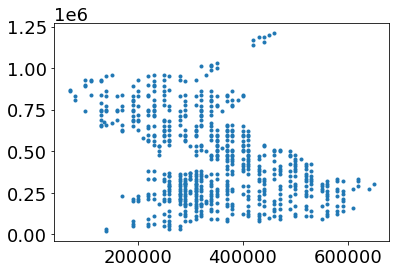

In [87]:
plt.plot(sq_web_codes['E_2_FIG_10KM'],sq_web_codes['N_2_FIG_10KM'],'.')

# correlation of soil moisture squares

In [ ]:
SQUARE – 1km square sampling site code (text)
PLOT - Plot identifier (one of 5 plots within each 1 km square) (number)
YEAR - Year of survey (number)
PH – Fresh soil pH (in water) (number)
LOI - Percentage loss on ignition (number)
C_CONC_LOI - Carbon concentration calculated from loss on ignition (g/kg). Using bespoke CS conversion value for %C calculation of 0.55xLOI. (number)
C_STOCK_LOI - Carbon stock calculated from loss on ignition (t/ha). Using bespoke CS conversion value for %C calculation of 0.55xLOI. (number)
BULK_DENSITY - Bulk density (g/cm3) (number)
MOISTURE - Percentage moisture content (number)
N_PERCENT - Percentage nitrogen (number)
N_STOCK - Nitrogen stock (0-15cm) (t/ha) (number)
PO4_OLSEN - Olsen Phosphorus (mg/kg) (number)
LC07 (text) - ITE Land Class 2007 (Bunce et al., 1996; Bunce et al., 1981, Bunce et al., 2007). 
LC07_NUM (number) - ITE Land Class 2007 (numeric code).
COUNTRY (text) – Country in which 1km square is located (England ENG, Scotland SCO, Wales WAL)
COUNTY07 (text) – County (Eng & Wal) or Council (Sco) in which 1km square is located
EZ_DESC_07 (text) - Countryside Survey Environmental Zone description.  See: https://catalogue.ceh.ac.uk/documents/0cfd454a-d035-416c-80dc-803c65470ea2 



In [18]:
data = post({
  "metadata": {
      "tags": ["soil"],
      "years": ["2007"]
  },
  "columns": ["MOISTURE","SQUARE","PH","LOI"]
})
data.groupby('SQUARE').mean()

,MOISTURE,PH,LOI
SQUARE,,,
AAVJXT,29.452936,6.6575,8.191548
ABOBUL,24.075031,6.4780,6.982702
ADHCCF,47.731953,5.3120,15.090771
AHIACC,23.093809,6.5150,4.224647
AHKTWX,18.019368,8.2150,3.894813
...,...,...,...
ZVXGSY,29.130665,6.4600,7.377850
ZWGBOD,72.053203,4.6840,49.660186
ZWKRMA,35.073375,5.3700,7.706792


In [106]:
#data.dropna().groupby('SQUARE').mean()
sorted(data)

['ACTO',
 'AC_COLL_TOTAL',
 'AL',
 'ARAN',
 'AS',
 'BULK_DENSITY',
 'CD',
 'CHGE',
 'CHLI',
 'CHTO',
 'COAD',
 'COEN',
 'COLA',
 'COLL_TOTAL',
 'CONE',
 'COPE',
 'COPU',
 'COSM',
 'COUNTRY',
 'COUNTY07',
 'CR',
 'CU',
 'C_CONC_LOI',
 'C_STOCK_LOI',
 'DIAD',
 'DILA',
 'DIPL',
 'DIPP',
 'DR',
 'EZ_DESC_07',
 'GAST',
 'HEMI',
 'HG',
 'HYME',
 'ISOP',
 'LC07',
 'LC07_NUM',
 'LEAD',
 'LELA',
 'LOI',
 'MC_RATIO',
 'MIN_N_STOCK',
 'MN',
 'MO',
 'MOISTURE',
 'MWD1',
 'MWD2',
 'NEMA',
 'NEMM',
 'NE_NMINTOT',
 'NE_NO3N_PROP_NMIN',
 'NI',
 'N_PERCENT',
 'N_STOCK',
 'OLIG',
 'OPIL',
 'PAUR',
 'PB',
 'PH',
 'PLOT',
 'PO4_OLSEN',
 'PROT',
 'PSEU',
 'PSIZE',
 'PSOC',
 'PULM',
 'SE',
 'SHANNON',
 'SQUARE',
 'SYMP',
 'THYN',
 'THYP',
 'TI',
 'TOTAL_CATCH',
 'TOTAL_TAXA',
 'VOL_SON',
 'VOL_WS',
 'YEAR',
 'ZN']

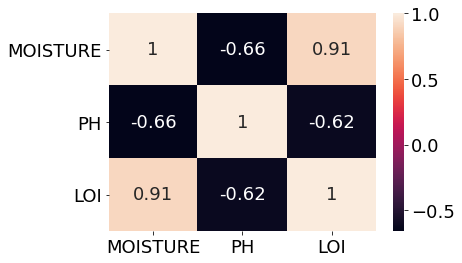

In [110]:

corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

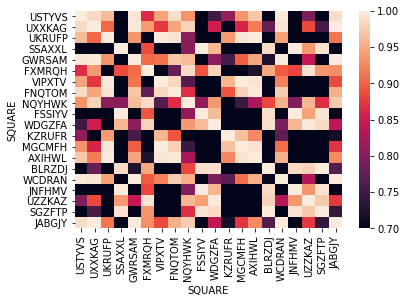

In [169]:
corrMatrix = data.dropna().groupby('SQUARE').mean().sample(n=20).T.corr()
corrMatrix
sn.heatmap(corrMatrix, annot=False,vmin=0.70)
plt.show()

## Draw graph, form edge when correlation > 0.8

In [20]:
# Turn corrMatrix to (source, receptor, R) data frame then filter R > 0.8
corrMatrix = corrMatrix[corrMatrix > 0.8].unstack().dropna().rename(index={0: "SQUARE1", 1: "SQUARE2", 2: "Pearson"})


In [21]:
corrMatrix = corrMatrix[corrMatrix < 1.00].reset_index(level=1).rename(columns={"SQUARE": "SQUARE2", 0: "Pearson"}).reset_index()
corrMatrix

,SQUARE,SQUARE2,Pearson
0,RAGOWO,KXYDPJ,0.976024
1,RAGOWO,QVZIXI,0.970411
2,RAGOWO,EAHYYJ,0.805399
3,RAGOWO,SXFQWQ,0.990651
4,RAGOWO,FOXRQT,0.973548
...,...,...,...
295,COCEEQ,SZHMUG,0.982260
296,COCEEQ,RTQIEV,0.994790
297,COCEEQ,NQYHWK,0.980023
298,COCEEQ,CRWYWA,0.801591


In [150]:
graph = nx.from_pandas_edgelist(corrMatrix, source = "SQUARE", target = "SQUARE2", edge_attr = "Pearson")


In [23]:
corrMatrix.head()

,SQUARE,SQUARE2,Pearson
0,RAGOWO,KXYDPJ,0.976024
1,RAGOWO,QVZIXI,0.970411
2,RAGOWO,EAHYYJ,0.805399
3,RAGOWO,SXFQWQ,0.990651
4,RAGOWO,FOXRQT,0.973548


In [159]:
weights - 0.8

TypeError: unsupported operand type(s) for -: 'list' and 'float'

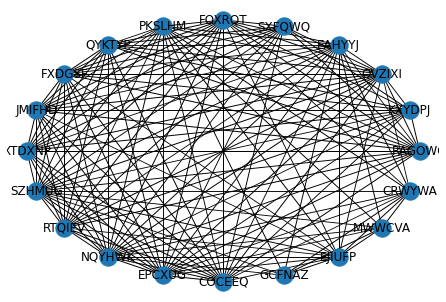

In [165]:
#nx.draw_networkx(graph)
edges = graph.edges()
weights = [graph[u][v]['Pearson'] for u,v in edges]
nx.draw_circular(graph, width=weights,with_labels=True)


In [2]:
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,
urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)

NameError: name 'Basemap' is not defined

<Figure size 720x648 with 0 Axes>

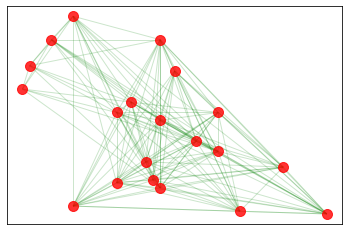

In [114]:
#mx, my = m(sq_web_codes['E_2_FIG_10KM'].values, sq_web_codes['N_2_FIG_10KM'].values)  # add to Basemap

mx = sq_web_codes['E_2_FIG_10KM'].values
my = sq_web_codes['N_2_FIG_10KM'].values

pos = {}
for count, elem in enumerate (sq_web_codes['WEB_ID']):
     pos[elem] = (mx[count], my[count])
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', alpha=0.2, arrows = False)


NameError: name 'set_size' is not defined

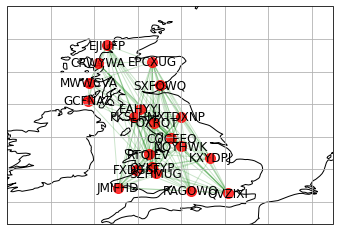

In [139]:
import cartopy.crs as ccrs


pos = {}
for count, elem in enumerate (sq_web_codes['WEB_ID']):
    pos[elem] = (OSGB36toWGS84(mx[count],my[count]))[::-1] 

central_lon, central_lat = 0, 50
extent = [-10, 5, 50, 60]
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extent)
#ax.gridlines()
ax.coastlines(resolution='50m')
nx.draw_networkx_nodes(G = graph, pos = pos,node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos,edge_color='g', alpha=0.2, arrows = False)
nx.draw_networkx_labels(graph,pos, label_pos =10.3)
set_size(5,5)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  after removing the cwd from sys.path.


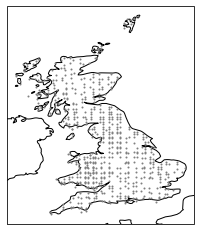

In [113]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(mx,my,
         color='gray', marker='o',linestyle='', markersize = 1,
         transform=ccrs.OSGB(),
         )
ax.coastlines(resolution='50m')




In [126]:
import mplleaflet
pos = {}
for count, elem in enumerate (sq_web_codes['WEB_ID']):
    pos[elem] = (OSGB36toWGS84(mx[count],my[count]))[::-1] 
    
fig, ax = plt.subplots()

nx.draw_networkx_nodes(graph,pos=pos,node_size=10,node_color='red',edge_color='k',alpha=.5, with_labels=True)
nx.draw_networkx_edges(graph,pos=pos,edge_color='gray', alpha=.1)
nx.draw_networkx_labels(graph,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)

In [123]:
pos

{'ZTHUIF': (53.327977087477926, 10.03489361027385),
 'RZMHKP': (53.40022030658121, 10.206908411964228),
 'AZFZMV': (53.152759961400946, 9.082974014315843),
 'BBIJIG': (53.1094291871286, 9.522209162475887),
 'LCLMLO': (53.16751199507619, 9.83883746595527),
 'SXXOPZ': (53.30019929260379, 9.423291290698298),
 'NGQBRD': (53.255428780691155, 9.863438886967593),
 'BJUBLC': (52.43313005294714, 6.980046150419908),
 'SHOJSV': (52.610678116535226, 7.0166194713000625),
 'PEVPIP': (52.5992158257808, 7.16236530799535),
 'GPKWZZ': (52.71075572829651, 6.8889157418798765),
 'FGGQSX': (52.67625668303068, 7.327013179956658),
 'KVEVJD': (50.583927668836, 5.0644721322370225),
 'OQQSNF': (50.55726910276637, 5.484618960121983),
 'QYXARR': (50.65550842191657, 5.358616008895872),
 'RLHVZO': (50.646420964034355, 5.498853021117533),
 'YUCTHB': (50.83385716190567, 5.3867771852535995),
 'CIPHOQ': (50.82471157746414, 5.527538204733979),
 'QVCPLP': (50.894975460944984, 5.823811137174588),
 'TZYVRC': (50.97431910102